In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn gudhi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import glob
import sklearn.manifold as manifold

# Create a list of tuples, each containing:
# 1. A name identifying the sample size (e.g., '500')
# 2. The corresponding point cloud loaded from a NumPy file
samples = [
    (filename.split('_')[-1].split('.')[0], np.load(filename))
    for filename in glob.glob('dragon_vrip_sampled_*.npy')
]

# Sort samples by their numeric values (convert string names to integers for proper sorti
samples.sort(key=lambda x: int(x[0]))
print("Samples loaded and sorted")

l = len(samples)

# Use Multidimensional Scaling (MDS) to visualize topological differences between samples
# This will allow us to visualize the relationships between the samples based on their persistence intervals
# MDS (Multidimensional Scaling) reduces high-dimensional distance matrices to 2D for visualization
mds = manifold.MDS(
    n_components=2,        # Reduce to 2 dimensions for plotting
    max_iter=3000,         # Maximum iterations for convergence
    eps=1e-9,             # Convergence tolerance
    dissimilarity="precomputed",  # Use precomputed distance matrices B0, B1, B2
    n_jobs=1,             # Number of parallel jobs
    n_init=1              # Number of initializations (silences warnings)
)


Samples loaded and sorted


Persistence intervals for 500 appended.
Persistence intervals for 750 appended.
Persistence intervals for 1000 appended.
Persistence intervals for 1250 appended.
Persistence intervals for 1500 appended.
Persistence intervals for 1750 appended.
Persistence intervals for 2000 appended.
Persistence intervals for 2250 appended.
Persistence intervals for 2500 appended.
Persistence intervals for 2750 appended.
Persistence intervals for 3000 appended.
Persistence intervals for 3250 appended.
Persistence intervals for 3500 appended.
Persistence intervals for 3750 appended.
Persistence intervals for 4000 appended.
Bottleneck distances for 750 and 500 computed.
Bottleneck distances for 1000 and 500 computed.
Bottleneck distances for 1000 and 750 computed.
Bottleneck distances for 1250 and 500 computed.
Bottleneck distances for 1250 and 750 computed.
Bottleneck distances for 1250 and 1000 computed.
Bottleneck distances for 1500 and 500 computed.
Bottleneck distances for 1500 and 750 computed.
Bot

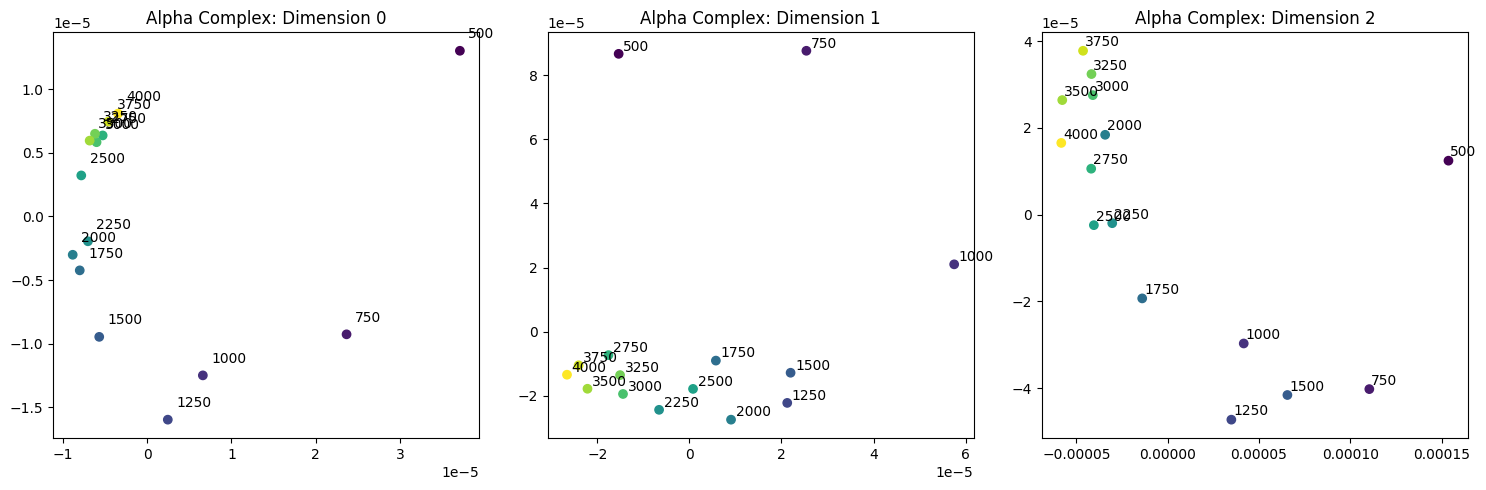

In [2]:
# Create lists to store persistence intervals for each homological dimension
# pl0: connected components (dimension 0)
# pl1: loops/cycles (dimension 1) 
# pl2: voids/cavities (dimension 2)
pl0 = []
pl1 = []
pl2 = []

# Process each sample to extract persistence intervals
for name, points in samples:
    # Create Alpha Complex from point cloud
    ac = gd.AlphaComplex(points=points)
    
    # Build simplex tree for topological analysis
    st = ac.create_simplex_tree()
    
    # Compute persistent homology
    bc = st.persistence()
    
    # Extract persistence intervals for each dimension and store them
    pl0.append(st.persistence_intervals_in_dimension(0))  # Connected components
    pl1.append(st.persistence_intervals_in_dimension(1))  # Loops/cycles
    pl2.append(st.persistence_intervals_in_dimension(2))  # Voids/cavities
    
    print(f"Persistence intervals for {name} appended.")

# # Display the shape of persistence intervals for each sample and dimension
# for i, name in enumerate([s[0] for s in samples]):
#     print(f"{name}: dim0={pl0[i].shape}, dim1={pl1[i].shape}, dim2={pl2[i].shape}")

# Initialize distance matrices for each homological dimension
# B0: bottleneck distances for connected components (dimension 0)
# B1: bottleneck distances for loops/cycles (dimension 1) 
# B2: bottleneck distances for voids/cavities (dimension 2)
B0 = np.zeros((l, l))
B1 = np.zeros((l, l))
B2 = np.zeros((l, l))

# Compute pairwise bottleneck distances between persistence intervals
# Only compute upper triangle to avoid redundant calculations
for i in range(l):
    for j in range(i):
        # Calculate bottleneck distance between persistence intervals of samples i and j
        B0[i,j] = gd.bottleneck_distance(pl0[i], pl0[j])  # Dimension 0
        B1[i,j] = gd.bottleneck_distance(pl1[i], pl1[j])  # Dimension 1
        B2[i,j] = gd.bottleneck_distance(pl2[i], pl2[j])  # Dimension 2
        print(f"Bottleneck distances for {samples[i][0]} and {samples[j][0]} computed.")

# Make distance matrices symmetric by adding the transpose
# This fills in the lower triangle with the same values as the upper triangle
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()
B2 = B2 + B2.transpose()

# Apply MDS to each bottleneck distance matrix to get 2D coordinates
X0 = mds.fit_transform(B0)  # 2D embedding for dimension 0 (connected components)
X1 = mds.fit_transform(B1)  # 2D embedding for dimension 1 (loops/cycles)
X2 = mds.fit_transform(B2)  # 2D embedding for dimension 2 (voids/cavities)

# Create a single figure with 3 vertically stacked subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sample_names = [s[0] for s in samples]  # Extract sample names for labeling

# Plot dimension 0 embedding (connected components)
axes[0].scatter(X0[:, 0], X0[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset to avoid overlap with points
    axes[0].annotate(name, (X0[i, 0], X0[i, 1]), 
                    xytext=(X0[i, 0] + 0.000001, X0[i, 1] + 0.000001))
axes[0].set_title('Alpha Complex: Dimension 0')

# Plot dimension 1 embedding (loops/cycles)
axes[1].scatter(X1[:, 0], X1[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[1].annotate(name, (X1[i, 0], X1[i, 1]), 
                    xytext=(X1[i, 0] + 0.000001, X1[i, 1] + 0.000001))
axes[1].set_title('Alpha Complex: Dimension 1')

# Plot dimension 2 embedding (voids/cavities)
axes[2].scatter(X2[:, 0], X2[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[2].annotate(name, (X2[i, 0], X2[i, 1]), 
                    xytext=(X2[i, 0] + 0.000001, X2[i, 1] + 0.000001))
axes[2].set_title('Alpha Complex: Dimension 2')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# # Get sample names
# sample_names = [s[0] for s in samples]

# # Plot dimension 0 embedding
# plt.figure(figsize=(8, 6))
# plt.scatter(X0[:, 0], X0[:, 1], c=range(l), cmap='viridis')
# for i, name in enumerate(sample_names):
#     plt.annotate(name, (X0[i, 0], X0[i, 1]))
# plt.title('Dimension 0 (Connected Components)')
# plt.tight_layout()
# plt.show()

# # Plot dimension 1 embedding
# plt.figure(figsize=(8, 6))
# plt.scatter(X1[:, 0], X1[:, 1], c=range(l), cmap='viridis')
# for i, name in enumerate(sample_names):
#     plt.annotate(name, (X1[i, 0], X1[i, 1]))
# plt.title('Dimension 1 (Loops)')
# plt.tight_layout()
# plt.show()

# # Plot dimension 2 embedding
# plt.figure(figsize=(8, 6))
# plt.scatter(X2[:, 0], X2[:, 1], c=range(l), cmap='viridis')
# for i, name in enumerate(sample_names):
#     plt.annotate(name, (X2[i, 0], X2[i, 1]))
# plt.title('Dimension 2 (Voids)')
# plt.tight_layout()
# plt.show()

Persistence intervals for 500 appended.
Persistence intervals for 750 appended.
Persistence intervals for 1000 appended.
Persistence intervals for 1250 appended.
Persistence intervals for 1500 appended.
Persistence intervals for 1750 appended.
Persistence intervals for 2000 appended.
Persistence intervals for 2250 appended.
Persistence intervals for 2500 appended.
Persistence intervals for 2750 appended.
Persistence intervals for 3000 appended.
Persistence intervals for 3250 appended.
Persistence intervals for 3500 appended.
Persistence intervals for 3750 appended.
Persistence intervals for 4000 appended.
Bottleneck distances for 750 and 500 computed.
Bottleneck distances for 1000 and 500 computed.
Bottleneck distances for 1000 and 750 computed.
Bottleneck distances for 1250 and 500 computed.
Bottleneck distances for 1250 and 750 computed.
Bottleneck distances for 1250 and 1000 computed.
Bottleneck distances for 1500 and 500 computed.
Bottleneck distances for 1500 and 750 computed.
Bot

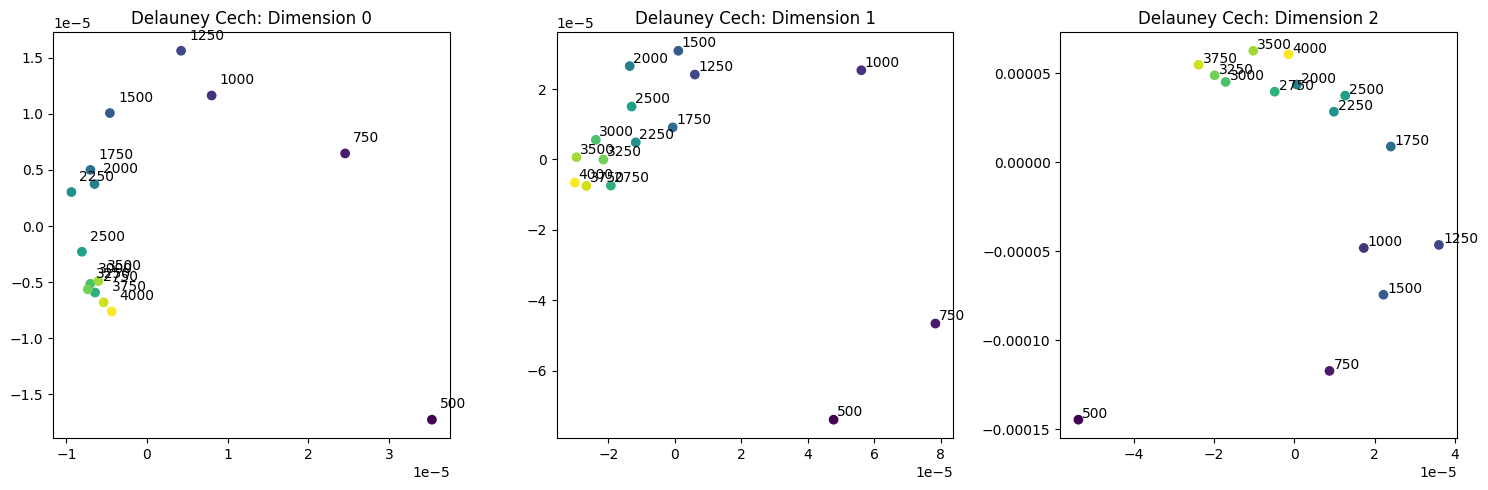

In [3]:
# Create lists to store persistence intervals for each homological dimension
# pl0: connected components (dimension 0)
# pl1: loops/cycles (dimension 1) 
# pl2: voids/cavities (dimension 2)
pl0 = []
pl1 = []
pl2 = []

# Process each sample to extract persistence intervals
for name, points in samples:
    # Create Alpha Complex from point cloud
    ac = gd.DelaunayCechComplex(points=points)
    
    # Build simplex tree for topological analysis
    st = ac.create_simplex_tree()
    
    # Compute persistent homology
    bc = st.persistence()
    
    # Extract persistence intervals for each dimension and store them
    pl0.append(st.persistence_intervals_in_dimension(0))  # Connected components
    pl1.append(st.persistence_intervals_in_dimension(1))  # Loops/cycles
    pl2.append(st.persistence_intervals_in_dimension(2))  # Voids/cavities
    
    print(f"Persistence intervals for {name} appended.")

# # Display the shape of persistence intervals for each sample and dimension
# for i, name in enumerate([s[0] for s in samples]):
#     print(f"{name}: dim0={pl0[i].shape}, dim1={pl1[i].shape}, dim2={pl2[i].shape}")

# Initialize distance matrices for each homological dimension
# B0: bottleneck distances for connected components (dimension 0)
# B1: bottleneck distances for loops/cycles (dimension 1) 
# B2: bottleneck distances for voids/cavities (dimension 2)
B0 = np.zeros((l, l))
B1 = np.zeros((l, l))
B2 = np.zeros((l, l))

# Compute pairwise bottleneck distances between persistence intervals
# Only compute upper triangle to avoid redundant calculations
for i in range(l):
    for j in range(i):
        # Calculate bottleneck distance between persistence intervals of samples i and j
        B0[i,j] = gd.bottleneck_distance(pl0[i], pl0[j])  # Dimension 0
        B1[i,j] = gd.bottleneck_distance(pl1[i], pl1[j])  # Dimension 1
        B2[i,j] = gd.bottleneck_distance(pl2[i], pl2[j])  # Dimension 2
        print(f"Bottleneck distances for {samples[i][0]} and {samples[j][0]} computed.")

# Make distance matrices symmetric by adding the transpose
# This fills in the lower triangle with the same values as the upper triangle
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()
B2 = B2 + B2.transpose()

# Apply MDS to each bottleneck distance matrix to get 2D coordinates
X0 = mds.fit_transform(B0)  # 2D embedding for dimension 0 (connected components)
X1 = mds.fit_transform(B1)  # 2D embedding for dimension 1 (loops/cycles)
X2 = mds.fit_transform(B2)  # 2D embedding for dimension 2 (voids/cavities)

# Create a single figure with 3 vertically stacked subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sample_names = [s[0] for s in samples]  # Extract sample names for labeling

# Plot dimension 0 embedding (connected components)
axes[0].scatter(X0[:, 0], X0[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset to avoid overlap with points
    axes[0].annotate(name, (X0[i, 0], X0[i, 1]), 
                    xytext=(X0[i, 0] + 0.000001, X0[i, 1] + 0.000001))
axes[0].set_title('Delauney Cech: Dimension 0')

# Plot dimension 1 embedding (loops/cycles)
axes[1].scatter(X1[:, 0], X1[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[1].annotate(name, (X1[i, 0], X1[i, 1]), 
                    xytext=(X1[i, 0] + 0.000001, X1[i, 1] + 0.000001))
axes[1].set_title('Delauney Cech: Dimension 1')

# Plot dimension 2 embedding (voids/cavities)
axes[2].scatter(X2[:, 0], X2[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[2].annotate(name, (X2[i, 0], X2[i, 1]), 
                    xytext=(X2[i, 0] + 0.000001, X2[i, 1] + 0.000001))
axes[2].set_title('Delauney Cech: Dimension 2')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Processing sample: 500

Total points loaded: 500
Number of landmark points chosen: 75
Estimated data range: 0.25613123
Using max_alpha_value: 0.00065603

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 7829
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 55


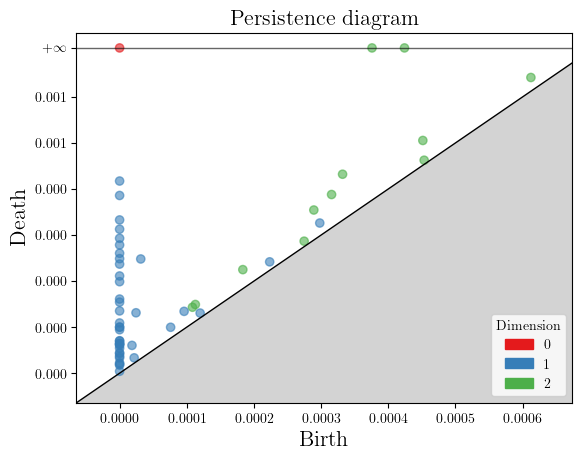


Processing sample: 750

Total points loaded: 750
Number of landmark points chosen: 112
Estimated data range: 0.25508875
Using max_alpha_value: 0.00065070

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 22835
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 82


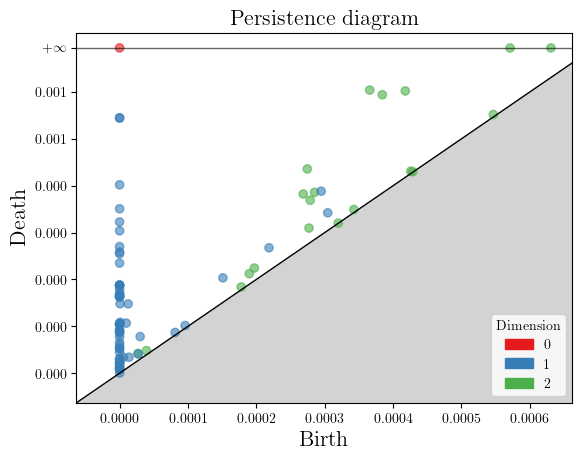


Processing sample: 1000

Total points loaded: 1000
Number of landmark points chosen: 150
Estimated data range: 0.26256555
Using max_alpha_value: 0.00068941

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 85781
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 117


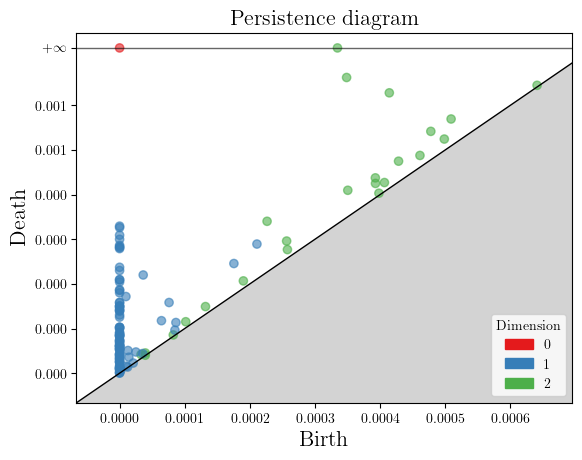


Processing sample: 1250

Total points loaded: 1250
Number of landmark points chosen: 187
Estimated data range: 0.25726140
Using max_alpha_value: 0.00066183

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 199583
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 156


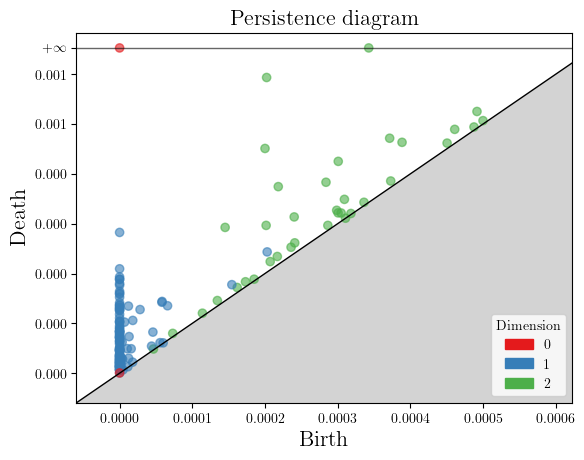


Processing sample: 1500

Total points loaded: 1500
Number of landmark points chosen: 225
Estimated data range: 0.25981233
Using max_alpha_value: 0.00067502

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 298196
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 177


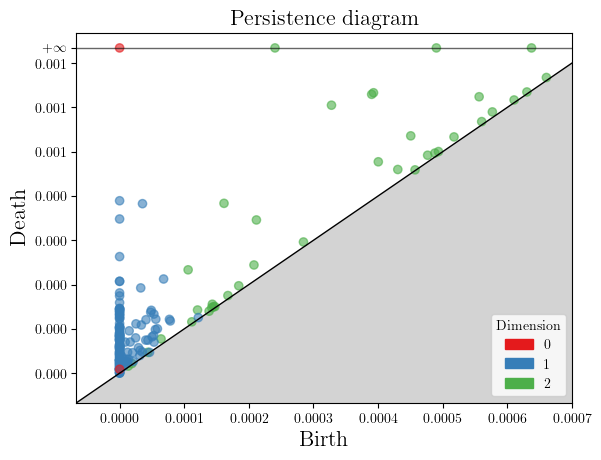


Processing sample: 1750

Total points loaded: 1750
Number of landmark points chosen: 262
Estimated data range: 0.26251742
Using max_alpha_value: 0.00068915

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 551504
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 217


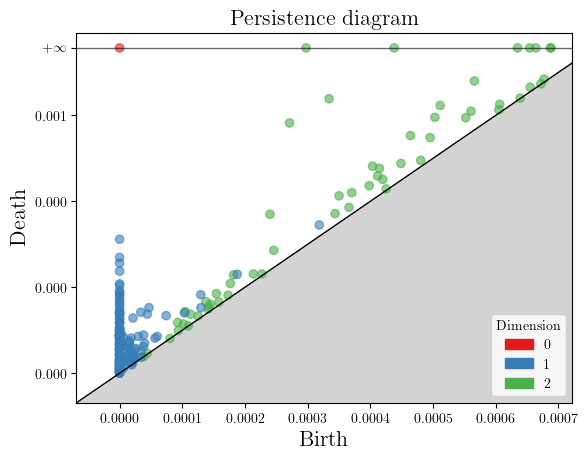


Processing sample: 2000

Total points loaded: 2000
Number of landmark points chosen: 300
Estimated data range: 0.26210266
Using max_alpha_value: 0.00068698

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 959541
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 247


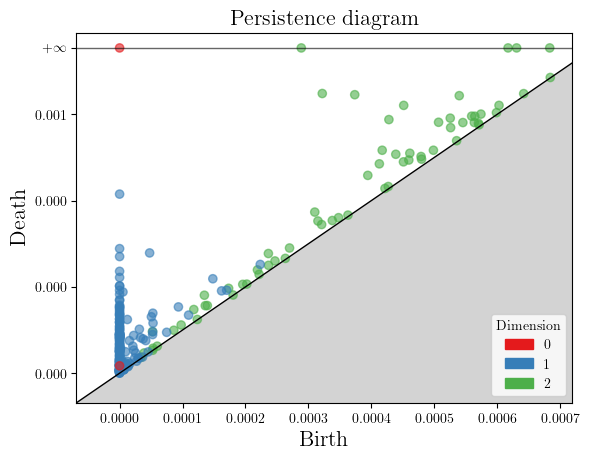


Processing sample: 2250

Total points loaded: 2250
Number of landmark points chosen: 337
Estimated data range: 0.26611257
Using max_alpha_value: 0.00070816

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 1733189
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 283


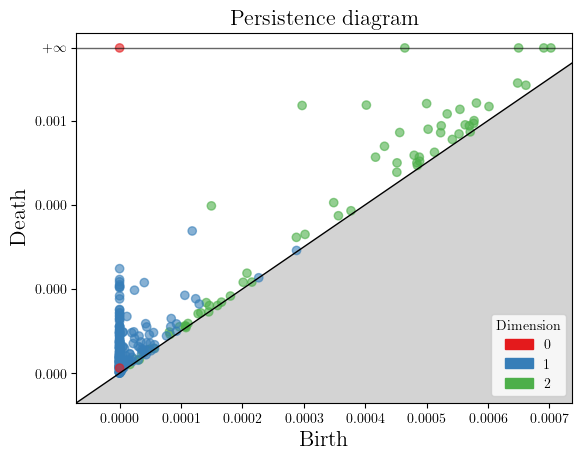


Processing sample: 2500

Total points loaded: 2500
Number of landmark points chosen: 375
Estimated data range: 0.26152021
Using max_alpha_value: 0.00068393

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 3193209
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 330


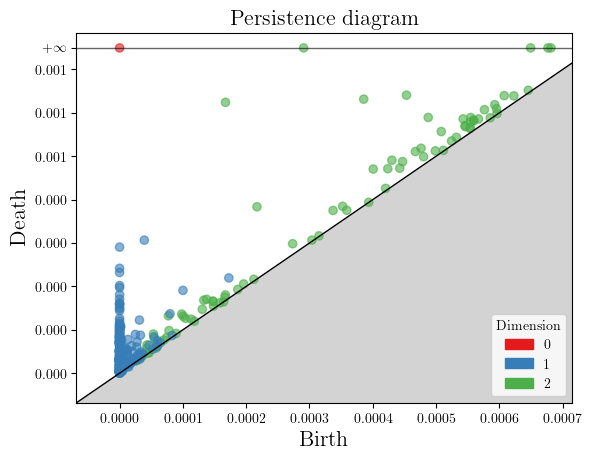


Processing sample: 2750

Total points loaded: 2750
Number of landmark points chosen: 412
Estimated data range: 0.26175544
Using max_alpha_value: 0.00068516

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 4115177
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 333


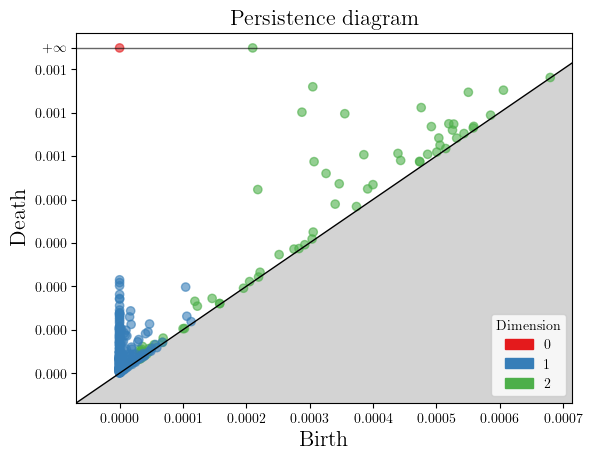


Processing sample: 3000

Total points loaded: 3000
Number of landmark points chosen: 450
Estimated data range: 0.26320821
Using max_alpha_value: 0.00069279

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 6096629
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 374


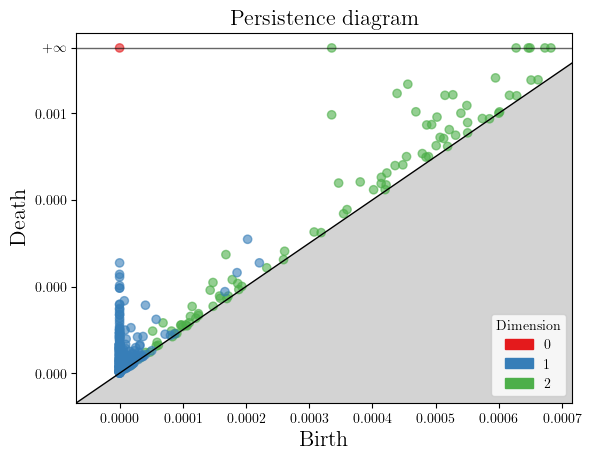


Processing sample: 3250

Total points loaded: 3250
Number of landmark points chosen: 487
Estimated data range: 0.26546007
Using max_alpha_value: 0.00070469

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 9311313
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 389


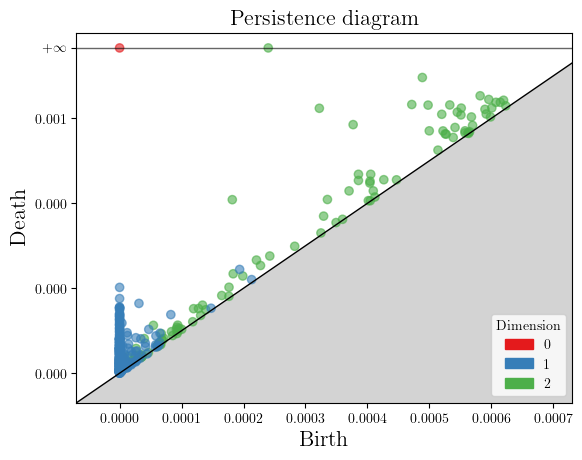


Processing sample: 3500

Total points loaded: 3500
Number of landmark points chosen: 525
Estimated data range: 0.26582614
Using max_alpha_value: 0.00070664

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 9998706
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 429


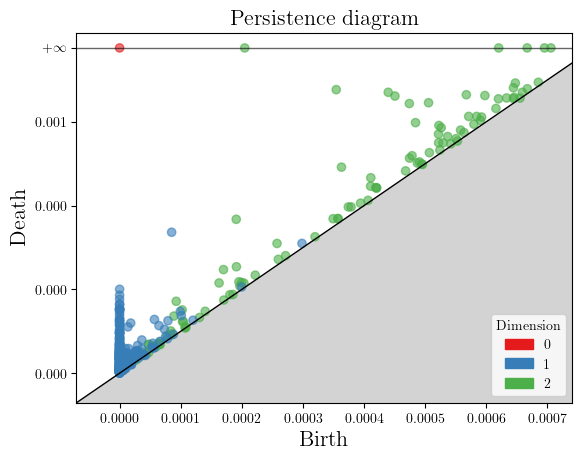


Processing sample: 3750

Total points loaded: 3750
Number of landmark points chosen: 562
Estimated data range: 0.26295310
Using max_alpha_value: 0.00069144

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 16576830
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 463


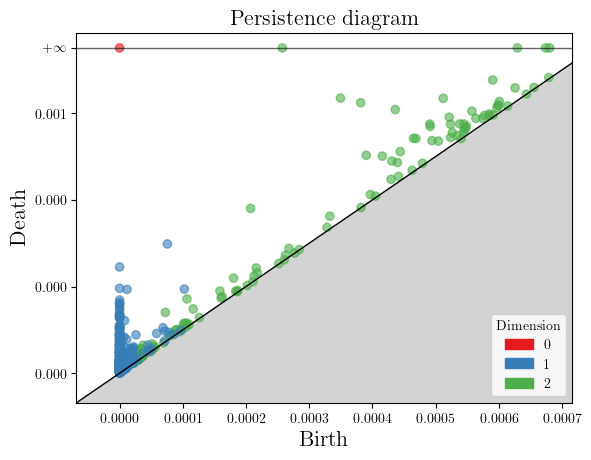


Processing sample: 4000

Total points loaded: 4000
Number of landmark points chosen: 600
Estimated data range: 0.26529336
Using max_alpha_value: 0.00070381

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 17692430
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 474


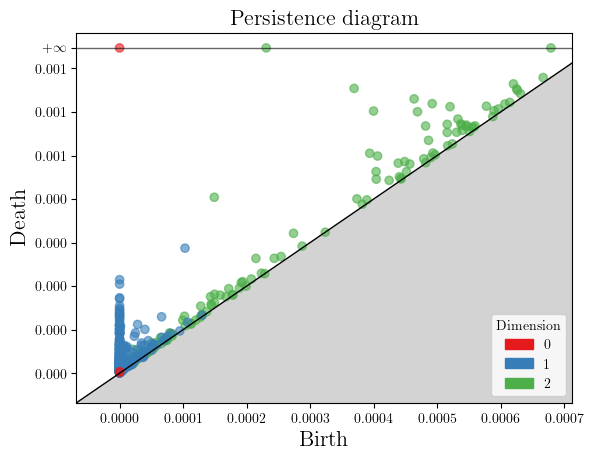

In [2]:
# Create lists to store persistence intervals for each homological dimension
# pl0: connected components (dimension 0)
# pl1: loops/cycles (dimension 1) 
# pl2: voids/cavities (dimension 2)
pl0 = []
pl1 = []
pl2 = []

for name, points in samples:
    
    print(f"\nProcessing sample: {name}")

    # 1. Define Witness Points
    # The full set of data points will serve as witness points.
    witness_points = points

    # 2. Choose Landmark Points
    # We need to select a subset of `witness_points` to be `landmark_points`.
    # A common strategy is random sampling. The number of landmarks significantly affects the computational cost and the approximation quality of the complex.
    # For example, we choose a maximum of 500 landmarks, or 20% of total points, whichever is smaller, to keep the complex manageable.
    num_total_points = witness_points.shape[0]
    target_num_landmarks = int(0.15 * num_total_points)

    num_landmarks = max(1, target_num_landmarks)
    print(f"\nTotal points loaded: {num_total_points}")
    print(f"Number of landmark points chosen: {num_landmarks}")

    # Randomly select indices for landmark points without replacement
    landmark_indices = np.random.choice(num_total_points, num_landmarks, replace=False)
    landmark_points = witness_points[landmark_indices]

    # 3. Create the Euclidean Witness Complex
    # The `max_alpha_value` parameter acts as a maximum allowed "radius" for a simplex to be included in the complex.
    # - If too small, the complex might be empty or very sparse.
    # - If too large, it might be too dense and computationally expensive.
    # A heuristic to estimate `max_alpha_value` is to consider a fraction of the data's overall range or diameter.
    min_coords = np.min(witness_points, axis=0)
    max_coords = np.max(witness_points, axis=0)
    data_range = np.linalg.norm(max_coords - min_coords) # Diagonal length of bounding box
    
    # A common starting point: 5-15% of the data range
    estimated_max_alpha_value = data_range * 0.1
    
    # Fallback for very small or zero range (e.g., all points identical)
    if estimated_max_alpha_value < 1e-6:
        estimated_max_alpha_value = 1.0 

    max_alpha_value = estimated_max_alpha_value ** 2 # create_simplex_tree expects squared radius
    print(f"Estimated data range: {data_range:.8f}")
    print(f"Using max_alpha_value: {max_alpha_value:.8f}")
    
    witness_complex = gd.EuclideanWitnessComplex(
        landmarks=landmark_points,
        witnesses=witness_points
    )

    # 4. Create the Simplex Tree from the witness complex
    simplex_tree = witness_complex.create_simplex_tree(max_alpha_square=max_alpha_value, limit_dimension=3)

    print("\n--- Euclidean Witness Complex Information ---")
    print(f"Successfully created a Euclidean Witness Complex.")
    print(f"Number of simplices in the complex: {simplex_tree.num_simplices()}")
    print(f"Dimension of the complex: {simplex_tree.dimension()}")

    # 5. Compute persistent homology
    print("\nComputing persistent homology...")
    persistence = simplex_tree.persistence()
    print(f"Number of persistence pairs: {len(persistence)}")

    # 6. plot persistence diagram
    gd.plot_persistence_diagram(persistence, max_intervals=10_000_000, legend=True)
    plt.show()

    # 7. Extract persistence intervals for each dimension and store them
    pl0.append(simplex_tree.persistence_intervals_in_dimension(0))  # Connected components
    pl1.append(simplex_tree.persistence_intervals_in_dimension(1))  # Loops/cycles
    pl2.append(simplex_tree.persistence_intervals_in_dimension(2))  # Voids/cavities

    # #print persistence intervals for each dimension
    # for i, intervals in enumerate([pl0[-1], pl1[-1], pl2[-1]]):
    #     print(f"Persistence intervals for {name} in dimension {i}: {intervals.shape[0]} intervals")
    #     if intervals.shape[0] > 0:
    #         for interval in intervals:
    #             print(f"  Interval: {interval[0]:.8f} to {interval[1]:.8f}, Length: {interval[1] - interval[0]:.8f}")
                

In [3]:
B0 = np.zeros((l, l))
B1 = np.zeros((l, l))
B2 = np.zeros((l, l))

# Compute pairwise bottleneck distances between persistence intervals
# Only compute upper triangle to avoid redundant calculations
for i in range(l):
    for j in range(i):
        # Calculate bottleneck distance between persistence intervals of samples i and j
        B0[i,j] = gd.bottleneck_distance(pl0[i], pl0[j])  # Dimension 0
        B1[i,j] = gd.bottleneck_distance(pl1[i], pl1[j])  # Dimension 1
        B2[i,j] = gd.bottleneck_distance(pl2[i], pl2[j])  # Dimension 2
        print(f"Bottleneck distances for {samples[i][0]} and {samples[j][0]} computed.")

# print bottleneck distances by sample
print("\nBottleneck distances of dimension 0:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B0[i,j]:.8f}")
print("\nBottleneck distances of dimension 1:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B1[i,j]:.8f}")
print("\nBottleneck distances of dimension 2:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B2[i,j]:.8f}")

Bottleneck distances for 750 and 500 computed.
Bottleneck distances for 1000 and 500 computed.
Bottleneck distances for 1000 and 750 computed.
Bottleneck distances for 1250 and 500 computed.
Bottleneck distances for 1250 and 750 computed.
Bottleneck distances for 1250 and 1000 computed.
Bottleneck distances for 1500 and 500 computed.
Bottleneck distances for 1500 and 750 computed.
Bottleneck distances for 1500 and 1000 computed.
Bottleneck distances for 1500 and 1250 computed.
Bottleneck distances for 1750 and 500 computed.
Bottleneck distances for 1750 and 750 computed.
Bottleneck distances for 1750 and 1000 computed.
Bottleneck distances for 1750 and 1250 computed.
Bottleneck distances for 1750 and 1500 computed.
Bottleneck distances for 2000 and 500 computed.
Bottleneck distances for 2000 and 750 computed.
Bottleneck distances for 2000 and 1000 computed.
Bottleneck distances for 2000 and 1250 computed.
Bottleneck distances for 2000 and 1500 computed.
Bottleneck distances for 2000 an

In [4]:
# compare persistence intervals for each dimension by counting how many intervals die at infinity
print("\nCounting intervals that die at infinity for each dimension:")
sample_names = [s[0] for s in samples]

for dim, pl_list in enumerate([pl0, pl1, pl2]):
    print(f"\nDimension {dim}:")
    for i, (name, intervals) in enumerate(zip(sample_names, pl_list)):
        count_infinity = sum(1 for interval in intervals if interval[1] == float('inf'))
        print(f"  {name}: {count_infinity} intervals die at infinity")



Counting intervals that die at infinity for each dimension:

Dimension 0:
  500: 1 intervals die at infinity
  750: 1 intervals die at infinity
  1000: 1 intervals die at infinity
  1250: 1 intervals die at infinity
  1500: 1 intervals die at infinity
  1750: 1 intervals die at infinity
  2000: 1 intervals die at infinity
  2250: 1 intervals die at infinity
  2500: 1 intervals die at infinity
  2750: 1 intervals die at infinity
  3000: 1 intervals die at infinity
  3250: 1 intervals die at infinity
  3500: 1 intervals die at infinity
  3750: 1 intervals die at infinity
  4000: 1 intervals die at infinity

Dimension 1:
  500: 0 intervals die at infinity
  750: 0 intervals die at infinity
  1000: 0 intervals die at infinity
  1250: 0 intervals die at infinity
  1500: 0 intervals die at infinity
  1750: 0 intervals die at infinity
  2000: 0 intervals die at infinity
  2250: 0 intervals die at infinity
  2500: 0 intervals die at infinity
  2750: 0 intervals die at infinity
  3000: 0 inter

In [11]:
# Find the global maximum finite death value across all dimensions
all_intervals = pl0 + pl1 + pl2
global_max_death = max(
    interval[1]
    for intervals in all_intervals
    for interval in intervals
    if interval[1] != float('inf')
)
print(f"Global maximum death value: {global_max_death:.8f}")
import copy
pl0_n = copy.deepcopy(pl0)
pl1_n = copy.deepcopy(pl1)
pl2_n = copy.deepcopy(pl2)
# Change death value of infinity intervals in *_n to just above the global maximum and print them
for dim, (pl_list, pl_n_list) in enumerate(zip([pl0, pl1, pl2], [pl0_n, pl1_n, pl2_n])):
    print(f"\nDimension {dim}:")
    for name, intervals, intervals_n in zip(sample_names, pl_list, pl_n_list):
        k = 0
        for idx, interval in enumerate(intervals):
            if interval[1] == float('inf'):
                intervals_n[idx][1] = 2 * global_max_death
                k += 1
        print(f"  {name}: Updated infinity intervals to {k} intervals")

Global maximum death value: 0.00069606

Dimension 0:
  500: Updated infinity intervals to 1 intervals
  750: Updated infinity intervals to 1 intervals
  1000: Updated infinity intervals to 1 intervals
  1250: Updated infinity intervals to 1 intervals
  1500: Updated infinity intervals to 1 intervals
  1750: Updated infinity intervals to 1 intervals
  2000: Updated infinity intervals to 1 intervals
  2250: Updated infinity intervals to 1 intervals
  2500: Updated infinity intervals to 1 intervals
  2750: Updated infinity intervals to 1 intervals
  3000: Updated infinity intervals to 1 intervals
  3250: Updated infinity intervals to 1 intervals
  3500: Updated infinity intervals to 1 intervals
  3750: Updated infinity intervals to 1 intervals
  4000: Updated infinity intervals to 1 intervals

Dimension 1:
  500: Updated infinity intervals to 0 intervals
  750: Updated infinity intervals to 0 intervals
  1000: Updated infinity intervals to 0 intervals
  1250: Updated infinity intervals to

In [3]:
[len(pl0_item) for pl0_item in pl0]

[2, 1, 1, 1, 3, 2, 3, 2, 4, 4, 1, 1, 1, 1, 1]

In [4]:
[len(pl1_item) for pl1_item in pl1]

[59, 86, 122, 151, 171, 219, 221, 250, 301, 283, 304, 279, 304, 307, 295]

Bottleneck distances for 750 and 500 computed.
Bottleneck distances for 1000 and 500 computed.
Bottleneck distances for 1000 and 750 computed.
Bottleneck distances for 1250 and 500 computed.
Bottleneck distances for 1250 and 750 computed.
Bottleneck distances for 1250 and 1000 computed.
Bottleneck distances for 1500 and 500 computed.
Bottleneck distances for 1500 and 750 computed.
Bottleneck distances for 1500 and 1000 computed.
Bottleneck distances for 1500 and 1250 computed.
Bottleneck distances for 1750 and 500 computed.
Bottleneck distances for 1750 and 750 computed.
Bottleneck distances for 1750 and 1000 computed.
Bottleneck distances for 1750 and 1250 computed.
Bottleneck distances for 1750 and 1500 computed.
Bottleneck distances for 2000 and 500 computed.
Bottleneck distances for 2000 and 750 computed.
Bottleneck distances for 2000 and 1000 computed.
Bottleneck distances for 2000 and 1250 computed.
Bottleneck distances for 2000 and 1500 computed.
Bottleneck distances for 2000 an

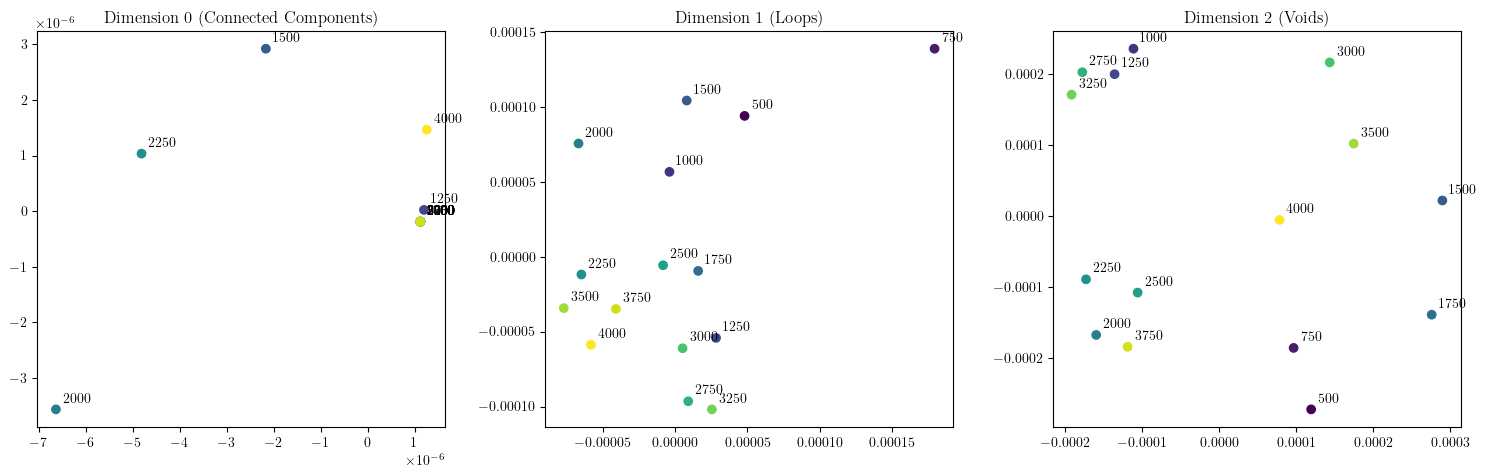

In [12]:
# Initialize distance matrices for each homological dimension
# B0: bottleneck distances for connected components (dimension 0)
# B1: bottleneck distances for loops/cycles (dimension 1) 
# B2: bottleneck distances for voids/cavities (dimension 2)
B0_n = np.zeros((l, l))
B1_n = np.zeros((l, l))
B2_n = np.zeros((l, l))

# Compute pairwise bottleneck distances between persistence intervals
# Only compute upper triangle to avoid redundant calculations
for i in range(l):
    for j in range(i):
        # Calculate bottleneck distance between persistence intervals of samples i and j
        B0_n[i,j] = gd.bottleneck_distance(pl0_n[i], pl0_n[j])  # Dimension 0
        B1_n[i,j] = gd.bottleneck_distance(pl1_n[i], pl1_n[j])  # Dimension 1
        B2_n[i,j] = gd.bottleneck_distance(pl2_n[i], pl2_n[j])  # Dimension 2
        print(f"Bottleneck distances for {samples[i][0]} and {samples[j][0]} computed.")

# print bottleneck distances by sample
print("\nBottleneck distances of dimension 0:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B0_n[i,j]:.8f}")
print("\nBottleneck distances of dimension 1:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B1_n[i,j]:.8f}")
print("\nBottleneck distances of dimension 2:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B2_n[i,j]:.8f}")

# Make distance matrices symmetric by adding the transpose
# This fills in the lower triangle with the same values as the upper triangle
B0_n = B0_n + B0_n.transpose()
B1_n = B1_n + B1_n.transpose()
B2_n = B2_n + B2_n.transpose()

# Apply MDS to each bottleneck distance matrix to get 2D coordinates
X0 = mds.fit_transform(B0_n)  # 2D embedding for dimension 0 (connected components)
X1 = mds.fit_transform(B1_n)  # 2D embedding for dimension 1 (loops/cycles)
X2 = mds.fit_transform(B2_n)  # 2D embedding for dimension 2 (voids/cavities)

# Create a single figure with 3 vertically stacked subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sample_names = [s[0] for s in samples]  # Extract sample names for labeling

# Plot dimension 0 embedding (connected components)
axes[0].scatter(X0[:, 0], X0[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset to avoid overlap with points
    axes[0].annotate(name, (X0[i, 0], X0[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
axes[0].set_title('Dimension 0 (Connected Components)')

# Plot dimension 1 embedding (loops/cycles)
axes[1].scatter(X1[:, 0], X1[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[1].annotate(name, (X1[i, 0], X1[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
axes[1].set_title('Dimension 1 (Loops)')

# Plot dimension 2 embedding (voids/cavities)
axes[2].scatter(X2[:, 0], X2[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[2].annotate(name, (X2[i, 0], X2[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
axes[2].set_title('Dimension 2 (Voids)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# # plot X0
# plt.figure(figsize=(8, 6))
# plt.scatter(X0[:, 0], X0[:, 1], c=range(l), cmap='viridis')
# for i, name in enumerate(sample_names):
#     plt.annotate(name, (X0[i, 0], X0[i, 1]), 
#                  xytext=(X0[i, 0] + 0.0000001, X0[i, 1] + 0.0000001))
# plt.title('Dimension 0 (Connected Components)')
# plt.show()

In [13]:
# compare Bi to Bi_n for i in [0, 1, 2]
print("\nComparing bottleneck distances before and after adjusting infinity intervals:")
for i in range(l):
    for j in range(i):
        # Only print if any of the Bk and Bk_n differ
        if not B0[i, j] == B0_n[i, j]:
            print(f"{samples[i][0]} vs {samples[j][0]}: B0={B0[i,j]:.8f}, B0_n={B0_n[i,j]:.8f}")
        if not B1[i, j] == B1_n[i, j]:
            print(f"{samples[i][0]} vs {samples[j][0]}: B1={B1[i,j]:.8f}, B1_n={B1_n[i,j]:.8f}")
        if not B2[i, j] == B2_n[i, j]:
            print(f"{samples[i][0]} vs {samples[j][0]}: B2={B2[i,j]:.8f}, B2_n={B2_n[i,j]:.8f}")


Comparing bottleneck distances before and after adjusting infinity intervals:
750 vs 500: B0=0.00000000, B0_n=0.00000000
1000 vs 500: B0=0.00000000, B0_n=0.00000000
1000 vs 500: B2=inf, B2_n=0.00048396
1000 vs 750: B0=0.00000000, B0_n=0.00000000
1000 vs 750: B2=inf, B2_n=0.00038050
1250 vs 500: B2=inf, B2_n=0.00048396
1250 vs 750: B2=inf, B2_n=0.00038050
1500 vs 500: B2=inf, B2_n=0.00037726
1500 vs 750: B2=inf, B2_n=0.00037726
1500 vs 1000: B2=inf, B2_n=0.00045091
1500 vs 1250: B2=inf, B2_n=0.00045091
1750 vs 500: B0=0.00000000, B0_n=0.00000000
1750 vs 500: B2=inf, B2_n=0.00037853
1750 vs 750: B0=0.00000000, B0_n=0.00000000
1750 vs 750: B2=inf, B2_n=0.00037853
1750 vs 1000: B0=0.00000000, B0_n=0.00000000
1750 vs 1000: B2=inf, B2_n=0.00047706
1750 vs 1250: B2=inf, B2_n=0.00047706
1750 vs 1500: B2=inf, B2_n=0.00036887
2000 vs 500: B2=inf, B2_n=0.00038046
2000 vs 750: B2=inf, B2_n=0.00038046
2000 vs 1000: B2=inf, B2_n=0.00038727
2000 vs 1250: B0=0.00000852, B0_n=0.00000852
2000 vs 1250: 

In [8]:
[len(p2_item) for p2_item in pl2]

[15, 26, 33, 45, 54, 52, 69, 80, 81, 97, 93, 99, 99, 103, 101]

B2[1, 0] = inf


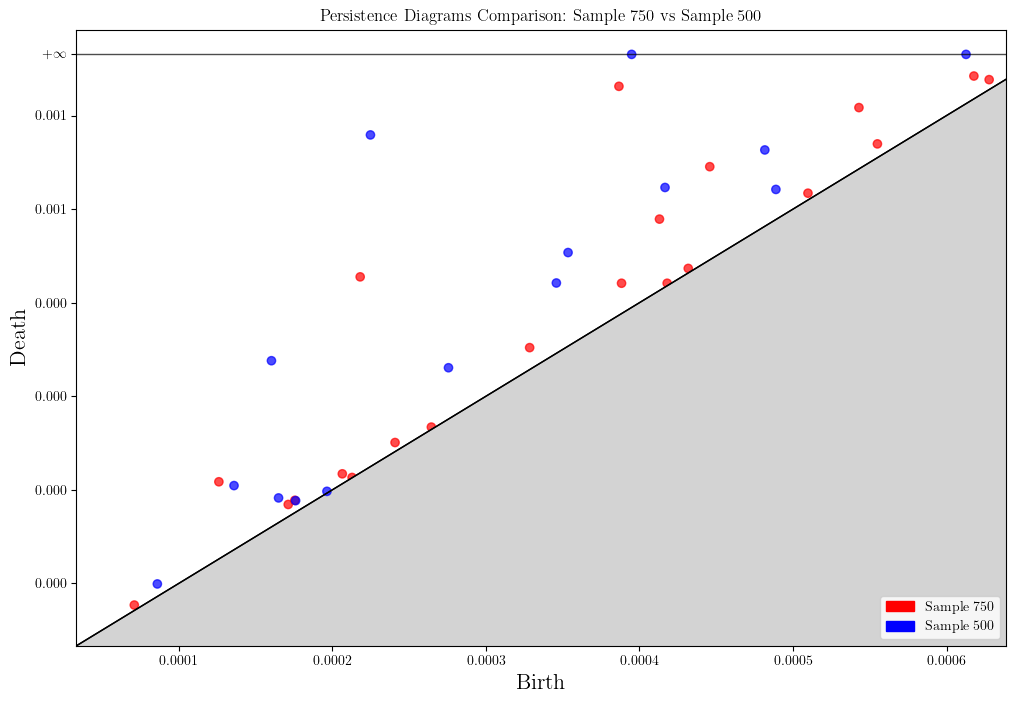

ValueError: B2[1, 0] = inf, check the persistence diagrams above.

In [27]:
# print the infinity entries in B2 with the matching persistence diagrams
for i in range(l):
    for j in range(i):
        if np.isinf(B2[i, j]):
            print(f"B2[{i}, {j}] = inf")
            fig, ax = plt.subplots(1, 1, figsize=(12, 8))
            gd.plot_persistence_diagram(pl2[i], max_intervals=10_000_000, axes=ax, alpha=0.7, colormap=((1,0,0),))
            gd.plot_persistence_diagram(pl2[j], max_intervals=10_000_000, axes=ax, alpha=0.7, colormap=((0,0,1),))
            ax.set_title(f'Persistence Diagrams Comparison: Sample {samples[i][0]} vs Sample {samples[j][0]}')
            
            # Add legend
            import matplotlib.patches as mpatches
            red_patch = mpatches.Patch(color='red', label=f'Sample {samples[i][0]}')
            blue_patch = mpatches.Patch(color='blue', label=f'Sample {samples[j][0]}')
            ax.legend(handles=[red_patch, blue_patch])
            
            plt.show()
            raise ValueError(f"B2[{i}, {j}] = inf, check the persistence diagrams above.")


In [ ]:
# Create lists to store persistence intervals for each homological dimension
# pl0: connected components (dimension 0)
# pl1: loops/cycles (dimension 1) 
# pl2: voids/cavities (dimension 2)
pl0 = []
pl1 = []
pl2 = []

for name, points in samples:
    
    print(f"\nProcessing sample: {name}")

    # 1. Define Witness Points
    # The full set of data points will serve as witness points.
    witness_points = points

    # 2. Choose Landmark Points
    # We need to select a subset of `witness_points` to be `landmark_points`.
    # A common strategy is random sampling. The number of landmarks significantly affects the computational cost and the approximation quality of the complex.
    # For example, we choose a maximum of 500 landmarks, or 20% of total points, whichever is smaller, to keep the complex manageable.
    num_total_points = witness_points.shape[0]
    target_num_landmarks = int(0.15 * num_total_points)

    num_landmarks = max(1, target_num_landmarks)
    print(f"\nTotal points loaded: {num_total_points}")
    print(f"Number of landmark points chosen: {num_landmarks}")

    # Randomly select indices for landmark points without replacement
    landmark_indices = np.random.choice(num_total_points, num_landmarks, replace=False)
    landmark_points = witness_points[landmark_indices]

    # 3. Create the Euclidean Witness Complex
    # The `max_alpha_value` parameter acts as a maximum allowed "radius" for a simplex to be included in the complex.
    # - If too small, the complex might be empty or very sparse.
    # - If too large, it might be too dense and computationally expensive.
    # A heuristic to estimate `max_alpha_value` is to consider a fraction of the data's overall range or diameter.
    min_coords = np.min(witness_points, axis=0)
    max_coords = np.max(witness_points, axis=0)
    data_range = np.linalg.norm(max_coords - min_coords) # Diagonal length of bounding box
    
    # A common starting point: 5-15% of the data range
    estimated_max_alpha_value = data_range * 0.1
    
    # Fallback for very small or zero range (e.g., all points identical)
    if estimated_max_alpha_value < 1e-6:
        estimated_max_alpha_value = 1.0 

    max_alpha_value = estimated_max_alpha_value ** 2 # create_simplex_tree expects squared radius
    print(f"Estimated data range: {data_range:.8f}")
    print(f"Using max_alpha_value: {max_alpha_value:.8f}")
    
    witness_complex = gd.EuclideanWitnessComplex(
        landmarks=landmark_points,
        witnesses=witness_points
    )

    # 4. Create the Simplex Tree from the witness complex
    simplex_tree = witness_complex.create_simplex_tree(max_alpha_square=max_alpha_value, limit_dimension=3)

    print("\n--- Euclidean Witness Complex Information ---")
    print(f"Successfully created a Euclidean Witness Complex.")
    print(f"Number of simplices in the complex: {simplex_tree.num_simplices()}")
    print(f"Dimension of the complex: {simplex_tree.dimension()}")

    # 5. Compute persistent homology
    print("\nComputing persistent homology...")
    persistence = simplex_tree.persistence()
    print(f"Number of persistence pairs: {len(persistence)}")

    # 6. plot persistence diagram
    gd.plot_persistence_diagram(persistence, max_intervals=10_000_000, legend=True)
    plt.show()

    # 7. Extract persistence intervals for each dimension and store them
    pl0.append(simplex_tree.persistence_intervals_in_dimension(0))  # Connected components
    pl1.append(simplex_tree.persistence_intervals_in_dimension(1))  # Loops/cycles
    pl2.append(simplex_tree.persistence_intervals_in_dimension(2))  # Voids/cavities

    # #print persistence intervals for each dimension
    # for i, intervals in enumerate([pl0[-1], pl1[-1], pl2[-1]]):
    #     print(f"Persistence intervals for {name} in dimension {i}: {intervals.shape[0]} intervals")
    #     if intervals.shape[0] > 0:
    #         for interval in intervals:
    #             print(f"  Interval: {interval[0]:.8f} to {interval[1]:.8f}, Length: {interval[1] - interval[0]:.8f}")
                
B0 = np.zeros((l, l))
B1 = np.zeros((l, l))
B2 = np.zeros((l, l))

# Compute pairwise bottleneck distances between persistence intervals
# Only compute upper triangle to avoid redundant calculations
for i in range(l):
    for j in range(i):
        # Calculate bottleneck distance between persistence intervals of samples i and j
        B0[i,j] = gd.bottleneck_distance(pl0[i], pl0[j])  # Dimension 0
        B1[i,j] = gd.bottleneck_distance(pl1[i], pl1[j])  # Dimension 1
        B2[i,j] = gd.bottleneck_distance(pl2[i], pl2[j])  # Dimension 2
        print(f"Bottleneck distances for {samples[i][0]} and {samples[j][0]} computed.")

# print bottleneck distances by sample
print("\nBottleneck distances of dimension 0:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B0[i,j]:.8f}")
print("\nBottleneck distances of dimension 1:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B1[i,j]:.8f}")
print("\nBottleneck distances of dimension 2:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B2[i,j]:.8f}")
# compare persistence intervals for each dimension by counting how many intervals die at infinity
print("\nCounting intervals that die at infinity for each dimension:")
sample_names = [s[0] for s in samples]

for dim, pl_list in enumerate([pl0, pl1, pl2]):
    print(f"\nDimension {dim}:")
    for i, (name, intervals) in enumerate(zip(sample_names, pl_list)):
        count_infinity = sum(1 for interval in intervals if interval[1] == float('inf'))
        print(f"  {name}: {count_infinity} intervals die at infinity")

# Find the global maximum finite death value across all dimensions
all_intervals = pl0 + pl1 + pl2
global_max_death = max(
    interval[1]
    for intervals in all_intervals
    for interval in intervals
    if interval[1] != float('inf')
)
print(f"Global maximum death value: {global_max_death:.8f}")
import copy
pl0_n = copy.deepcopy(pl0)
pl1_n = copy.deepcopy(pl1)
pl2_n = copy.deepcopy(pl2)
# Change death value of infinity intervals in *_n to just above the global maximum and print them
for dim, (pl_list, pl_n_list) in enumerate(zip([pl0, pl1, pl2], [pl0_n, pl1_n, pl2_n])):
    print(f"\nDimension {dim}:")
    for name, intervals, intervals_n in zip(sample_names, pl_list, pl_n_list):
        k = 0
        for idx, interval in enumerate(intervals):
            if interval[1] == float('inf'):
                intervals_n[idx][1] = global_max_death + 0.001
                k += 1
        print(f"  {name}: Updated infinity intervals to {k} intervals")
[len(pl0_item) for pl0_item in pl0]
[len(pl1_item) for pl1_item in pl1]
# Initialize distance matrices for each homological dimension
# B0: bottleneck distances for connected components (dimension 0)
# B1: bottleneck distances for loops/cycles (dimension 1) 
# B2: bottleneck distances for voids/cavities (dimension 2)
B0_n = np.zeros((l, l))
B1_n = np.zeros((l, l))
B2_n = np.zeros((l, l))

# Compute pairwise bottleneck distances between persistence intervals
# Only compute upper triangle to avoid redundant calculations
for i in range(l):
    for j in range(i):
        # Calculate bottleneck distance between persistence intervals of samples i and j
        B0_n[i,j] = gd.bottleneck_distance(pl0_n[i], pl0_n[j])  # Dimension 0
        B1_n[i,j] = gd.bottleneck_distance(pl1_n[i], pl1_n[j])  # Dimension 1
        B2_n[i,j] = gd.bottleneck_distance(pl2_n[i], pl2_n[j])  # Dimension 2
        print(f"Bottleneck distances for {samples[i][0]} and {samples[j][0]} computed.")

# print bottleneck distances by sample
print("\nBottleneck distances of dimension 0:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B0_n[i,j]:.8f}")
print("\nBottleneck distances of dimension 1:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B1_n[i,j]:.8f}")
print("\nBottleneck distances of dimension 2:")
for i in range(l):
    for j in range(i):
        print(f"  {samples[i][0]} vs {samples[j][0]}: {B2_n[i,j]:.8f}")

# Make distance matrices symmetric by adding the transpose
# This fills in the lower triangle with the same values as the upper triangle
B0_n = B0_n + B0_n.transpose()
B1_n = B1_n + B1_n.transpose()
B2_n = B2_n + B2_n.transpose()

# Apply MDS to each bottleneck distance matrix to get 2D coordinates
X0 = mds.fit_transform(B0_n)  # 2D embedding for dimension 0 (connected components)
X1 = mds.fit_transform(B1_n)  # 2D embedding for dimension 1 (loops/cycles)
X2 = mds.fit_transform(B2_n)  # 2D embedding for dimension 2 (voids/cavities)

# Create a single figure with 3 vertically stacked subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sample_names = [s[0] for s in samples]  # Extract sample names for labeling

# Plot dimension 0 embedding (connected components)
axes[0].scatter(X0[:, 0], X0[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset to avoid overlap with points
    axes[0].annotate(name, (X0[i, 0], X0[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
axes[0].set_title('Dimension 0 (Connected Components)')

# Plot dimension 1 embedding (loops/cycles)
axes[1].scatter(X1[:, 0], X1[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[1].annotate(name, (X1[i, 0], X1[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
axes[1].set_title('Dimension 1 (Loops)')

# Plot dimension 2 embedding (voids/cavities)
axes[2].scatter(X2[:, 0], X2[:, 1], c=range(l), cmap='viridis')
for i, name in enumerate(sample_names):
    # Add sample name labels with slight offset
    axes[2].annotate(name, (X2[i, 0], X2[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
axes[2].set_title('Dimension 2 (Voids)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print("\nComparing bottleneck distances before and after adjusting infinity intervals:")
for i in range(l):
    for j in range(i):
        # Only print if any of the Bk and Bk_n differ
        if not np.isclose(B0[i, j], B0_n[i, j]):
            print(f"{samples[i][0]} vs {samples[j][0]}: B0={B0[i,j]:.8f}, B0_n={B0_n[i,j]:.8f}")
        if not np.isclose(B1[i, j], B1_n[i, j]):
            print(f"{samples[i][0]} vs {samples[j][0]}: B1={B1[i,j]:.8f}, B1_n={B1_n[i,j]:.8f}")
        if not np.isclose(B2[i, j], B2_n[i, j]):
            print(f"{samples[i][0]} vs {samples[j][0]}: B2={B2[i,j]:.8f}, B2_n={B2_n[i,j]:.8f}")


Processing sample: 4000

Total points loaded: 4000
Number of landmark points chosen: 500
Estimated data range: 0.26529336
Using max_alpha_value: 0.00017595

--- Euclidean Witness Complex Information ---
Successfully created a Euclidean Witness Complex.
Number of simplices in the complex: 119414
Dimension of the complex: 3

Computing persistent homology...
Number of persistence pairs: 60477
